In [4]:
%matplotlib inline
#processes bagfile and runs optimization on each separated trajectory
#Schmittle
#romesc

import argparse
import rosbag
import math
import numpy as np
import tf.transformations
import librhc.utils as utils
import rhctensor
import librhc.types as types
import matplotlib.pyplot as plt

CROP_SQUARE_SZ = 200


def quaternion_to_angle(q):
    x, y, z, w = q.x, q.y, q.z, q.w
    roll, pitch, yaw = tf.transformations.euler_from_quaternion((x, y, z, w))
    return yaw

def separate_trajectories(bag):
    '''
    Separates trjactories by the correction timestamps
    '''
    bag = rosbag.Bag(bag)
    trajectories = []
    curr_traj = []
    position_set = False
    for topic, msg, t in bag.read_messages(topics=['/feedback','/sim_car_pose/pose','/vesc/low_level/ackermann_cmd_mux/input/teleop']):
        if topic == "/feedback":
            trajectories.append(curr_traj)
            curr_traj = []
        if topic == "/sim_car_pose/pose" and not position_set:
            position = msg.pose.position
            orientation = msg.pose.orientation
            curr_pose = (position.x,position.y,quaternion_to_angle(orientation))
            position_set = True
        if topic == '/vesc/low_level/ackermann_cmd_mux/input/teleop':
            drive =  msg.drive
            curr_u = (drive.steering_angle,drive.speed)
            if position_set:
                curr_traj.append([curr_pose,curr_u])
                position_set = False
    trajectories.append(curr_traj)
    bag.close()
    return trajectories

def get_map(bag):
    '''
    Gets map from bag and converts to a MapData type
    '''
    bag = rosbag.Bag(bag)
    for _, msg, _ in bag.read_messages(topics=['/map']):
        raw_map = msg
        break
    bag.close()
    map_data = types.MapData(
            name = "map",
            resolution = raw_map.info.resolution,
            origin_x = raw_map.info.origin.position.x,
            origin_y = raw_map.info.origin.position.y,
            orientation_angle = quaternion_to_angle(raw_map.info.origin.orientation),
            width = raw_map.info.width,
            height = raw_map.info.height,
            get_map_data = raw_map.data
    )
    return map_data

def objective_fn(w,mpc,traj,dtype):
    mpc.cost.dist_w = w[0]
    mpc.cost.obs_dist_w = w[1]
    mpc.cost.cost2go_w = w[2]
    cost = 0
    for p in traj:
        u_i = mpc.step(dtype(p[0]))
        if u_i is not None:
            cost+= np.linalg.norm(u_i - dtype(p[1]))
    return cost

def viz_map(map_img):
    import matplotlib.pyplot as plt
    plt.imshow(map_img, cmap='gray_r', vmin=0, vmax=255)
    plt.show()

def pixelMapInRobotFrame(map_data, pose_worldFrame, crop_square=200):
    import cv2
    pose_mapFrame = np.asarray([pose_worldFrame]) # this variable WILL get converted to mapFrame after next function call
    utils.world2mapnp(map_data, pose_mapFrame) #this is a bad function signature which does inplace assignment of pose_mapFrame (rather than explicitly returns a new object)...

    map_img = np.array(map_data._get_map_data)
    map_img = map_img.reshape([map_data.height, map_data.width]) #shape map into 2D image
    
    # Get all working parameters
    (h, w) = map_img.shape[:2]
    (cX, cY) = (w // 2, h // 2)           
    (x, y, th) = pose_mapFrame[0]
    x, y = int(x), int(y)
    th_r_deg = 90 - np.rad2deg(th)
    marg = crop_square // 2
    
    #convert 'unknown'=-1 and 'wall'=100 to value 1; keep freespace=0
    #map_img[map_img == -1] = 255
    #map_img[map_img == 100] = 255 
    
    #convert to float32 for OpenCV
    map_img = map_img.astype(np.float32)

    # Translation
    # TODO: need to verify that padding occurs during this process
    dx = x - cX
    dy = y - cY
    M_trans = np.float32([[1,0,-dx],[0,1,-dy]])
    map_img_trans = cv2.warpAffine(map_img, M_trans,(w,h))

    # Rotation
    M_rot = cv2.getRotationMatrix2D((cX, cY), -th_r_deg ,1)
    map_img_rot = cv2.warpAffine(map_img_trans, M_rot,(w,h))

    # Cropping
    # Check the crop region is valid
    assert(x > marg and x < w-marg and y > marg and y < h-marg), "Crop region too large for the map margins! Try padding your map or reducing crop region."
    map_img_crop = map_img_rot[cY-marg:cY+marg , cX-marg:cX+marg] 

    
    return map_img_crop, th_r_deg

In [5]:
def viz_with_arrows(map_imgs_and_arrows):
    n_col = min(len(map_imgs_and_arrows), 5)
    n_row = max(int(math.ceil(len(map_imgs_and_arrows) / n_col)), 1)

    _, axs = plt.subplots(n_row, n_col, figsize=(5 * n_col, 5 * n_row))
    axs = axs.flatten()
    for ((img, th, name), ax) in zip(map_imgs_and_arrows, axs):
        w, h = img.shape[:2]
        cX, cY = w // 2, h // 2
        ax.set_title(name)
        ax.imshow(img, cmap='gray_r', vmin=0, vmax=255, origin='lower')
        ax.arrow(cX, cY, 0, 50, color="green", width=3)
    plt.savefig("trials.pdf", dpi=600)

624
done


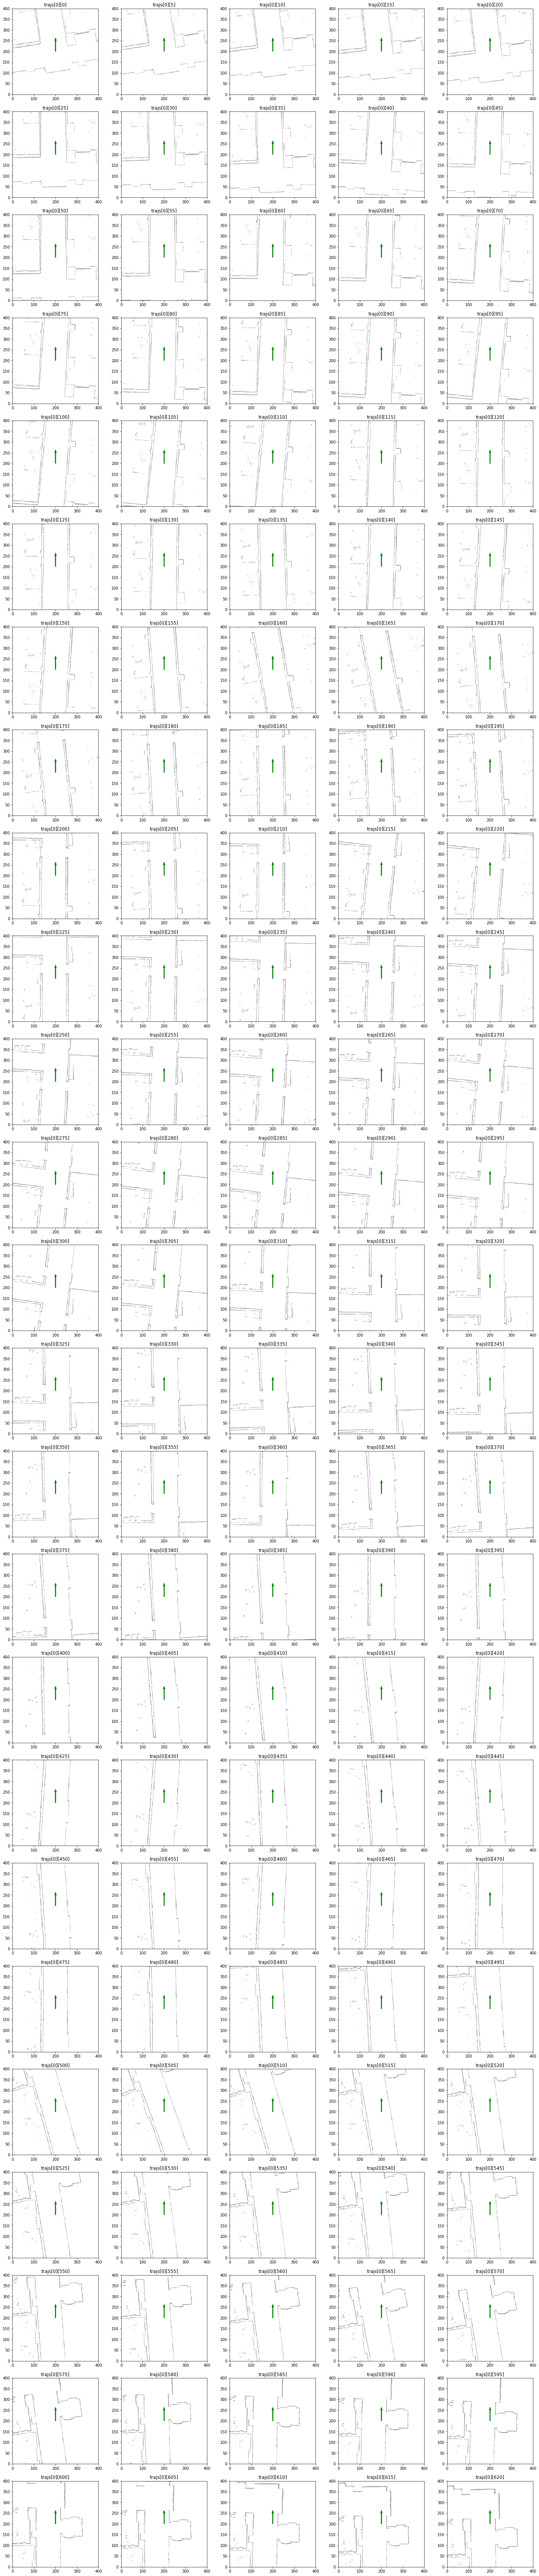

In [6]:
infile = "../rosbags/straight_traj.bag"
map_data = get_map(infile)

trajs = separate_trajectories(infile)
print len(trajs[0])
imgs = []
for i in range(0, len(trajs[0]), 5):
    (map_img_crop, arrow_angle) = pixelMapInRobotFrame(map_data, trajs[0][i][0], 400)
    imgs.append((map_img_crop, arrow_angle, "trajs[0][%d]" % i))

viz_with_arrows(imgs)
print('done')